# Testing the LSTM model and visualizing results

In the 'weather_nn_model', we trained an LSTM model that predicts the weather for the next 36 hours using the 96 previous ones. In this notebook, we test the model and visualise the results. 

### Importing libraries and loading the model and data

In [19]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error, r2_score

In [2]:
# load model
regressor = load_model('lstm_model.h5')

In [4]:
# summary model
regressor.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_7 (Bidirection (None, 96, 192)           75264     
_________________________________________________________________
dropout_22 (Dropout)         (None, 96, 192)           0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 96, 96)            110976    
_________________________________________________________________
dropout_23 (Dropout)         (None, 96, 96)            0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 96)                74112     
_________________________________________________________________
dropout_24 (Dropout)         (None, 96)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 36)               

In [5]:
# Getting data
df_nn = pd.read_csv('/Users/louispht/Dropbox/git_projects/weatherpredict/data_cleaning/weather_data_initial_clean.csv')
df_nn['dt_iso'] = pd.to_datetime(df_nn['dt_iso'], format='%Y-%m-%d %H:%M:%S.%f')
df_nn = df_nn.set_index('dt_iso')
df_nn = df_nn['temp']

In [6]:
# Splitting into training and test data, in a 80-20 split
split_point = int(len(df_nn)*(80/100))
nn_train = df_nn[:split_point]
nn_test = df_nn[split_point:]

In [7]:
# Transforming data into numpy array 
nn_train = nn_train.to_numpy().reshape(-1,1)
nn_test = nn_test.to_numpy().reshape(-1,1)

In [8]:
# Normalising using MinMaxScaler 
min_max_scaler = MinMaxScaler()

nn_train_norm = min_max_scaler.fit_transform(nn_train)
nn_test_norm = min_max_scaler.transform(nn_test)

In [9]:
# Creating train and test data
x_train = []
y_train = []
x_test = []
y_test = []

# Setting 'n_future' days to predict using 'n_past'days. 
n_future = 1.5
n_past = 4

# Getting number of hours 
n_future = int(n_future * 24)
n_past = int(n_past * 24) 

for i in range(0,len(nn_train_norm)-n_past-n_future+1):
    x_train.append(nn_train_norm[i : i + n_past , 0])     
    y_train.append(nn_train_norm[i + n_past : i + n_past + n_future , 0 ])
for i in range(0,len(nn_test_norm)-n_past-n_future+1):
    x_test.append(nn_test_norm[i : i + n_past , 0])  
    y_test.append(nn_test_norm[i + n_past : i + n_past + n_future , 0 ])

x_train , y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

x_train = np.reshape(x_train, (x_train.shape[0] , x_train.shape[1], 1) )
x_test = np.reshape(x_test, (x_test.shape[0] , x_test.shape[1], 1) )

print('Training data:')
print('x_train: ', x_train.shape)
print('y_train: ', y_train.shape)
print('x_test: ', x_test.shape)
print('y_test: ', y_test.shape)

Training data:
x_train:  (291478, 96, 1)
y_train:  (291478, 36)
x_test:  (72772, 96, 1)
y_test:  (72772, 36)


### Testing the model

We evaluate the model's performance. 

In [10]:
# Predicted temperature values
predicted_temperature_scaled = regressor.predict(x_test)

In [11]:
# Transform back into actual temperature values 
predicted_temperature = min_max_scaler.inverse_transform(predicted_temperature_scaled)
predicted_temperature.shape

(72772, 36)

In [12]:
# Get real_temperature
real_temperature = min_max_scaler.inverse_transform(y_test)
real_temperature.shape

(72772, 36)

In [21]:
real_temperature_train = min_max_scaler.inverse_transform(y_train)
real_temperature_train.shape

(291478, 36)

In [13]:
# Getting score
score = regressor.evaluate(x_test, y_test)

2275/2275 [==============================] - 122s 54ms/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0390


In [15]:
for i in range(len(regressor.metrics_names)):
    print("%s: %.4f" %(regressor.metrics_names[i], score[i]))

loss: 0.0028
mse: 0.0028
mae: 0.0390


The model seems to have performed very well. We need to keep in mind that those are scores obtained on scaled values. To have a better idea, let's evaluate performance on the retransformed data. 

In [16]:
# Predictions on training set
predicted_temperatures_train_scaled = regressor.predict(x_train)

In [17]:
# Transform back into actual temperature values 
predicted_temperature_train = min_max_scaler.inverse_transform(predicted_temperatures_train_scaled)
predicted_temperature_train.shape

(291478, 36)

In [24]:
# scores on actual values
MSE_train = mean_squared_error(real_temperature_train, predicted_temperature_train)
MSE_test = mean_squared_error(real_temperature, predicted_temperature)
MAE_train = mean_absolute_error(real_temperature_train, predicted_temperature_train)
MAE_test = mean_absolute_error(real_temperature, predicted_temperature)
MedAE_train = median_absolute_error(real_temperature_train, predicted_temperature_train)
MedAE_test = median_absolute_error(real_temperature, predicted_temperature)

print("Mean squared error on train set: %.2f" % MSE_train)
print("Mean squared error on test set: %.2f" % MSE_test)
print("Mean absolute error on train set: %.2f" % MAE_train)
print("Mean absolute error on test set: %.2f" % MAE_test)
print("Mediane absolute error on train set: %.2f" % MedAE_train)
print("Median absolute error on test set: %.2f" % MedAE_test)

Mean squared error on train set: 14.26
Mean squared error on test set: 13.33
Mean absolute error on train set: 2.78
Mean absolute error on test set: 2.71
Mediane absolute error on train set: 2.24
Median absolute error on test set: 2.21


#### Conclusion

We see that the LSTM model performs better than the linear regression model with less data. Our LSTM model was also quite simple, so there could be ways to improve it. However, this simple model took about 5 hours to train, whereas the Linear Regression took only a few seconds. Since we trained our model with Google Colab, there is a limit to the complexity of our model. 

There does not seem to be any overfitting issues, probably helped by the addition of dropouts. In order to improve the model, we could check the following: 
- Try different number of epochs. In this model we tried 20 epochs, and our model seemed to have stopped improving after ony a few epochs. The time saved could be put elsewhere. 
- Try different batch size. Our batch size was fairly large to save time, we could try to make it smaller, to see if there is a difference. 
- Play with the number of hours we use for prediction. We chose 96 hours here, again because we were limited in the time we can use the GPU. 
- Try a different RNN architecture. 

Let's visualise the predictions over a 36 days period. 

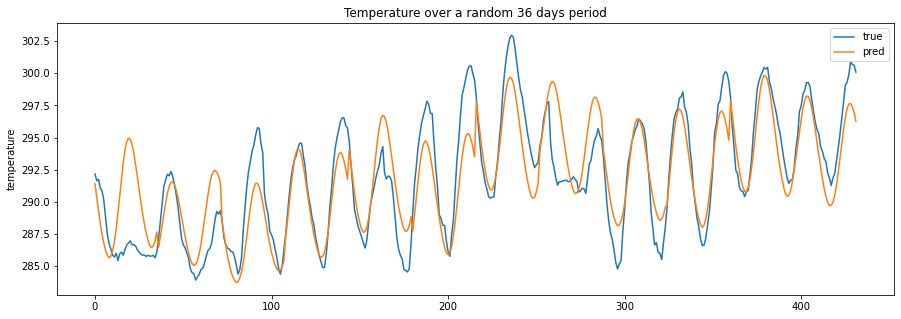

In [25]:
plt_test = []
plt_pred = []

for i in range(12):
    plt_test.append(real_temperature[1239+36*i])
    plt_pred.append(predicted_temperature[1239+36*i])

plt_test = np.concatenate(plt_test).ravel()
plt_pred = np.concatenate(plt_pred).ravel()

plt.figure(figsize=(15, 5))
plt.plot(plt_test, label='true')
plt.plot(plt_pred, label='pred')
plt.ylabel('temperature')
plt.title('Temperature over a random 36 days period')
plt.legend()
plt.show()

### Saving predictions 

In [26]:
import h5py

In [28]:
h5f = h5py.File('lstm_pred.h5', 'w')

In [29]:
h5f.create_dataset('predicted_temperature_test_scaled', data = predicted_temperature_scaled)
h5f.create_dataset('predicted_temperature_test', data = predicted_temperature)
h5f.create_dataset('predicted_temperature__train_scaled', data = predicted_temperatures_train_scaled)
h5f.create_dataset('predicted_temperature_train', data = predicted_temperature_train)

<HDF5 dataset "predicted_temperature_train": shape (291478, 36), type "<f4">

In [30]:
h5f.close()